### Import Libraries
Here we will use standard data science libraries for python including scikit-learn, numpy, pandas, and matplotlib.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from collections import OrderedDict
%matplotlib inline

### Provide your credentials to the runtime
This allows the colab access to underlying data stored in google cloud resources.

In [25]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


### Optional: Enable data table display
Colab includes the `google.colab.data_table` package the can be used to display large pandas dataframes as an interactive data table. It can be enabled with:

In [26]:
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


If you would prefer to return to the classic Pandas datafram display, you can disable this by running:


```
%unload_ext google.colab.data_table
```



### Use BigQuery via magics to retrieve Park Weather Data
The `google.cloud.bigquery` library also includes a magic command which runs a query and either displays the result or saves it to a variable as a `DataFrame`.

Load the query into a `Dataframe`

In [30]:
# Save output in a variable `weather_data`

%%bigquery weather_data --project sgcd-reportingengine-prj
SELECT
   PARK_ID
  ,case
    when lower(Forecast_Weather) like '%rain%' OR lower(Forecast_Weather) like '%shower%' OR lower(Forecast_Weather) like '%drizzle%' then 'Rain'
    when lower(Forecast_Weather) like '%partly%' OR lower(Forecast_Weather) like '%mostly%' then 'Partly Cloudy'
    when lower(Forecast_Weather) like '%cloud%' then 'Clouds'
    else 'Clear'
   end Forecast_Weather
  ,case
    when lower(Actual_Weather) like '%rain%' or lower(Actual_Weather) like '%shower%' OR lower(Actual_Weather) like '%drizzle%' then 'Rain'
    when lower(Actual_Weather) like '%partly%' OR lower(Actual_Weather) like '%mostly%' OR lower(Actual_Weather) like '%overcast%' then 'Partly Cloudy'
    when lower(Actual_Weather) like '%cloud%' then 'Clouds'
    else 'Clear'
  end Actual_Weather
  ,coalesce(Forecast_Attendance, 0) as Forecast_Attendance
  ,coalesce(Projected_Attendance, 0) as Projected_Attendance
  ,coalesce(Budget_Attendance, 0) as Budget_Attendance
  ,coalesce(Actual_Attendance, 0) as Actual_Attendance
 FROM `sgcd-reportingengine-prj.test.CA_DailyParkInfo`
 where length(coalesce(Forecast_Weather, '')) > 0

Query is running:   0%|          |

Downloading:   0%|          |

Display the `Dataframe` content.

In [31]:
# display the `DataFrame` content.
weather_data

,PARK_ID,Forecast_Weather,Actual_Weather,Forecast_Attendance,Projected_Attendance,Budget_Attendance,Actual_Attendance
0,1,Rain,Clear,3700,2900,4500,2502
1,1,Rain,Rain,1500,500,3100,444
2,1,Clear,Clear,2200,2900,2200,2967
3,1,Clear,Clear,10500,11800,9000,12228
4,1,Clear,Clear,22300,0,23200,23469
...,...,...,...,...,...,...,...
579,1,Clear,Clear,24500,23300,24800,18389
580,1,Clear,Clear,8500,7300,8200,7683
581,1,Partly Cloudy,Clear,11400,14600,11400,13762
582,1,Partly Cloudy,Clear,3100,3000,2900,3222


### Adjust text features
With the data now loaded, we can move on to adjusting text columns into categories. The following step will convert forecast and actual weather text values such as `Clear` or `Rain` to numeric equivalents, and then apply that over the `Dataframe`.

In [32]:
weather_category_dict = {'Clear':0, 'Partly Cloudy':1, 'Cloudy':2, 'Rain':3, 'None':np.nan}

weather_data.Forecast_Weather = pd.Categorical(weather_data.Forecast_Weather, categories=weather_category_dict)
weather_data['Forecast_Weather'] = weather_data.Forecast_Weather.cat.codes

weather_data.Actual_Weather = pd.Categorical(weather_data.Actual_Weather, categories=weather_category_dict)
weather_data['Actual_Weather'] = weather_data.Actual_Weather.cat.codes

weather_data

,PARK_ID,Forecast_Weather,Actual_Weather,Forecast_Attendance,Projected_Attendance,Budget_Attendance,Actual_Attendance
0,1,3,0,3700,2900,4500,2502
1,1,3,3,1500,500,3100,444
2,1,0,0,2200,2900,2200,2967
3,1,0,0,10500,11800,9000,12228
4,1,0,0,22300,0,23200,23469
...,...,...,...,...,...,...,...
579,1,0,0,24500,23300,24800,18389
580,1,0,0,8500,7300,8200,7683
581,1,1,0,11400,14600,11400,13762
582,1,1,0,3100,3000,2900,3222


### Shape the training data
We can now shape the appropriate input features and output values to prepare for training. You can uncomment one of the `feature_names`
declarations depending on which attendance projection you wish to analyze against.

Shape the input

In [33]:
feature_names = ["Forecast_Weather", "Projected_Attendance"]
#feature_names = ["Forecast_Weather", "Forecasted_Attendance"]
#feature_names = ["Forecast_Weather", "Budget_Attendance"]
attendance_output_name = "Actual_Attendance"

X = weather_data[feature_names]
X.head()

,Forecast_Weather,Projected_Attendance
0,3,2900
1,3,500
2,0,2900
3,0,11800
4,0,0


Shape the output

In [34]:
y_attendance = weather_data[attendance_output_name]
y_attendance.head()

0     2502
1      444
2     2967
3    12228
4    23469
Name: Actual_Attendance, dtype: Int64

### Split Training and Test Data
The next step is to properly split our training data into samples for training and verification or testing. The command below will select random samples of training data and reserve ~20% of the sample data for testing.

In [35]:
X_train_attendance, X_test_attendance, y_train_attendance, y_test_attendance = train_test_split(X, y_attendance, test_size=0.2)

### Initialize and prepare model
We can now setup and initialize our training model. For this application a Linear Regression model can be used since its a simple and direct association we are looking for between weather and attendance. Additional predictive models can be explored in the future.

In [36]:
attendance_model = LinearRegression()
attendance_model.fit(X_train_attendance.values, y_train_attendance.values)

LinearRegression()

### Predict Values
Now the model is used over the test data to generate predictions for attendance.

In [37]:
attendance_predictions = attendance_model.predict(X_test_attendance.values)
attendance_predictions

array([ 4029.12449858,  9820.00563435, 18887.1631508 , 14403.90033601,
        8340.04585254,  9640.43359529,  7865.8087311 ,  2800.44632978,
       14303.26844914,  2915.5393731 ,  3080.65025571, 15330.6828442 ,
        6644.36114054, 13182.45274544, 13275.85405408,  3174.05156435,
        4510.59219824, 19361.40027223,  2161.09832575, 14676.87368371,
        2915.5393731 ,  2735.96733405,  9733.83490393, 12722.67678046,
       20654.55743676,  3662.74984224, 12442.47285454,  5803.74936276,
        2534.70356031,  3281.91402944,  4963.13758499,  3289.14460767,
        8153.24323525, 13096.28201503,  3748.92057265, 15143.88022691,
       12341.84096767,  3375.31533809, 15718.74923522,  8979.39385657,
        1399.42670016, 15984.49200469, 13742.86059729,  3360.85418163,
       11407.82788125,  1974.29570846, 12816.0780891 ,  3756.15115088,
       21775.37314046,  7679.00611382,  4029.12449858, 20094.14958491,
       15517.48546148,  2426.84109522, 24304.43905201,  8620.24977846,
      

## Calculate accuracy
The following step calculates the root mean square error (RMSE) and plots test/predicted values to assess the accuracy of our model.

In [38]:
attendance_error_metric = mean_squared_error(y_test_attendance, attendance_predictions, squared=False)
print(f"The Root Mean Square Error of the attendance model is: {round(attendance_error_metric, 3)}")

The Root Mean Square Error of the attendance model is: 1131.31


Text(0.5, 1.0, 'Predicted vs. Actual Attendance values')

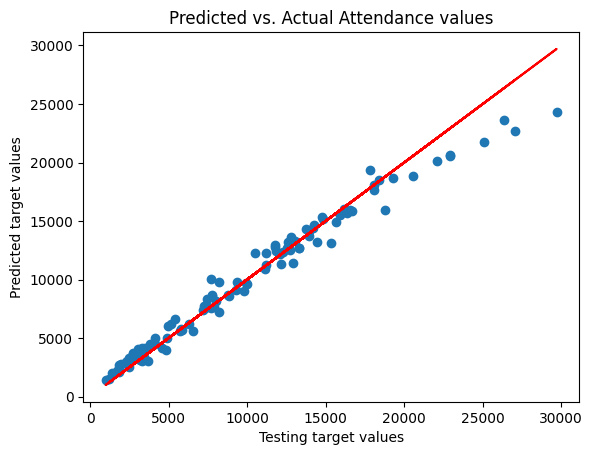

In [39]:
fig, ax = plt.subplots()
ax.scatter(y_test_attendance, attendance_predictions)
ax.plot(y_test_attendance, y_test_attendance, color='red')
ax.set_xlabel('Testing target values')
ax.set_ylabel('Predicted target values')
ax.set_title('Predicted vs. Actual Attendance values')

## Make Predictions
We can now apply the model to an example value to see the correlation of weather conditions against the anticipated attendance.

In [40]:
forecast_attendance = 10000
attendance = attendance_model.predict([
    [0, forecast_attendance],
    [1, forecast_attendance],
    [2, forecast_attendance],
    [3, forecast_attendance]
])

import math
print(f"Weather adjusted attendance using '{feature_names[1]}' of [{forecast_attendance}]:")
print(f"Clear:\t\t\t{math.floor(attendance[0])}")
print(f"Partly Cloudy:\t\t{math.floor(attendance[1])}")
print(f"Cloudy:\t\t\t{math.floor(attendance[2])}")
print(f"Rain:\t\t\t{math.floor(attendance[3])}")

Weather adjusted attendance using 'Projected_Attendance' of [10000]:
Clear:			10107
Partly Cloudy:		10006
Cloudy:			9906
Rain:			9805
